In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

## Предпосылки

**Гиперпараметры** - параметры алгоритмов, значения которых устанавливаются перед запуском процесса обучения.

**Параметры** напротив вычисляются во время обучения.

Гиперпараметры оказывают существенное влияние на модель и итоговое качество, поэтому целесообразно подбирать их особым образом

## Подготовка данных

In [3]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
y = 1 - y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.25)

## Grid Search

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [5]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression()),
    ]
)

In [6]:
model = pipeline.fit(X_train, y_train)
y_pred_simple = model.predict(X_test)
print(classification_report(y_test, y_pred_simple))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        90
           1       0.98      0.96      0.97        53

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



#### Оптимизация гиперпараметров

In [7]:
parameters = {
    'scaler__with_mean': [True, False],
    'clf__C': np.linspace(0.01, 1, 10),
    'clf__penalty': ['l2', 'none'],
    'clf__random_state': [2023],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    n_jobs=2,
    verbose=1,
)

In [8]:
%%time

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: user 433 ms, sys: 103 ms, total: 535 ms
Wall time: 10.3 s


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', LogisticRegression())]),
             n_jobs=2,
             param_grid={'clf__C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'clf__penalty': ['l2', 'none'],
                         'clf__random_state': [2023],
                         'scaler__with_mean': [True, False]},
             verbose=1)

In [9]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

clf__C: 0.12
clf__penalty: l2
clf__random_state: 2023
scaler__with_mean: True


In [10]:
y_pred_optimized = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_optimized))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        90
           1       0.98      0.98      0.98        53

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



##  Randomized Search

In [11]:
from sklearn.model_selection import RandomizedSearchCV

In [12]:
parameters = {
    'scaler__with_mean': [True, False],
    'clf__C': np.linspace(0.01, 1, 10),
    'clf__penalty': ['l2', 'none'],
    'clf__random_state': [2023],
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameters,
    n_iter=10,
    random_state=2023,
    n_jobs=4,
    verbose=1,
)

In [13]:
%%time

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 236 ms, sys: 113 ms, total: 349 ms
Wall time: 5.29 s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf', LogisticRegression())]),
                   n_jobs=4,
                   param_distributions={'clf__C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                                        'clf__penalty': ['l2', 'none'],
                                        'clf__random_state': [2023],
                                        'scaler__with_mean': [True, False]},
                   random_state=2023, verbose=1)

In [14]:
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

clf__C: 1.0
clf__penalty: l2
clf__random_state: 2023
scaler__with_mean: False


In [15]:
y_pred_optimized = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_optimized))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        90
           1       0.98      0.98      0.98        53

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



## Halving Grid Search

In [16]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

In [17]:
%%time

X, y = make_classification(n_samples=400, n_features=12, random_state=0)

clf = RandomForestClassifier(n_estimators=20, random_state=0)

param_dist = {
    "max_depth": [3, None],
    "max_features": np.arange(1, 6),
    "min_samples_split": np.arange(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
}

rsh = HalvingRandomSearchCV(
    estimator=clf,
    param_distributions=param_dist, 
    factor=2, 
    random_state=0,
)
rsh.fit(X, y)

CPU times: user 10.1 s, sys: 83.4 ms, total: 10.2 s
Wall time: 14.7 s


HalvingRandomSearchCV(estimator=RandomForestClassifier(n_estimators=20,
                                                       random_state=0),
                      factor=2,
                      param_distributions={'bootstrap': [True, False],
                                           'criterion': ['gini', 'entropy'],
                                           'max_depth': [3, None],
                                           'max_features': array([1, 2, 3, 4, 5]),
                                           'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
                      random_state=0)

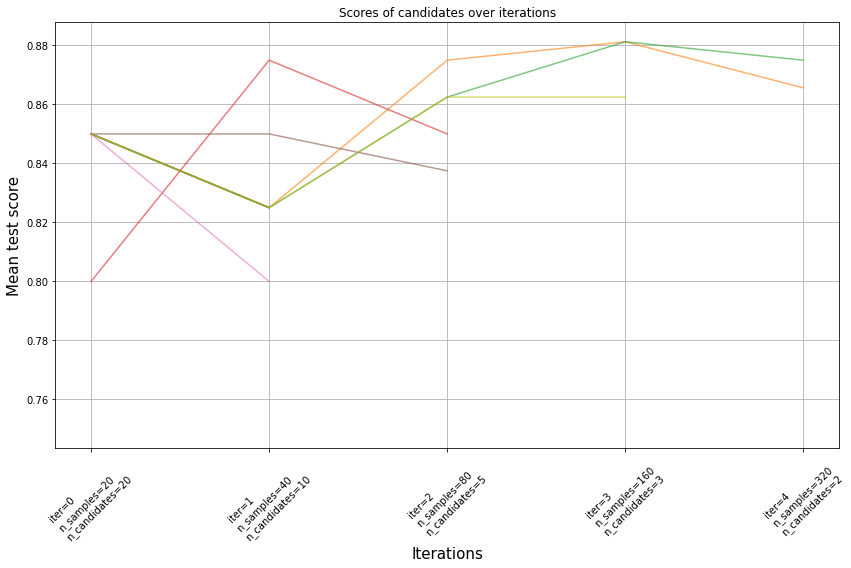

In [18]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", 
    columns="params_str",
     values="mean_test_score",
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]

ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("Mean test score", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()